# Introduction: Transfer Learning in PyTorch

In this notebook, we'll see how to use PyTorch to train a classifier to identify 101 different objects in images. Through this project, we'll get familiar with the basics of transfer learning, PyTorch, convolutional neural networks, and inference. 

## Dataset: CalTech 101

The dataset is the [CalTech 101 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) of images from 101 categories. There are about 40 to 800 images in each category. 

In [2]:
# PyTorch 
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
import seaborn as sns

# Printing out all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#### Parameters

The parameters in this cell can be changed as needed. I'm going to be training with 2 gpus, but your setup will probably be different. 

In [3]:
# Location of data
datadir = '/home/wjk68/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 64

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
2 gpus detected.


## Data Exploration

We can do a brief exploration of the available images. There are a total of 100 categories, which I've already split into training (50%), validation (25%), and testing (25%) folders.

In [4]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)
    
    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending = False, inplace = True)
cat_df.head()
cat_df.tail()

,category,n_train,n_valid,n_test
4,airplanes,400,200,200
2,Motorbikes,398,200,200
0,Faces_easy,274,138,109
93,watch,119,60,60
1,Leopards,100,50,50


,category,n_train,n_valid,n_test
43,gerenuk,16,9,9
96,wild_cat,16,9,9
72,platypus,16,9,9
10,binocular,16,8,9
51,inline_skate,15,8,8


There are between 400 and 15 training images in each category. The low number of training images may result in reduced scores in some categories.

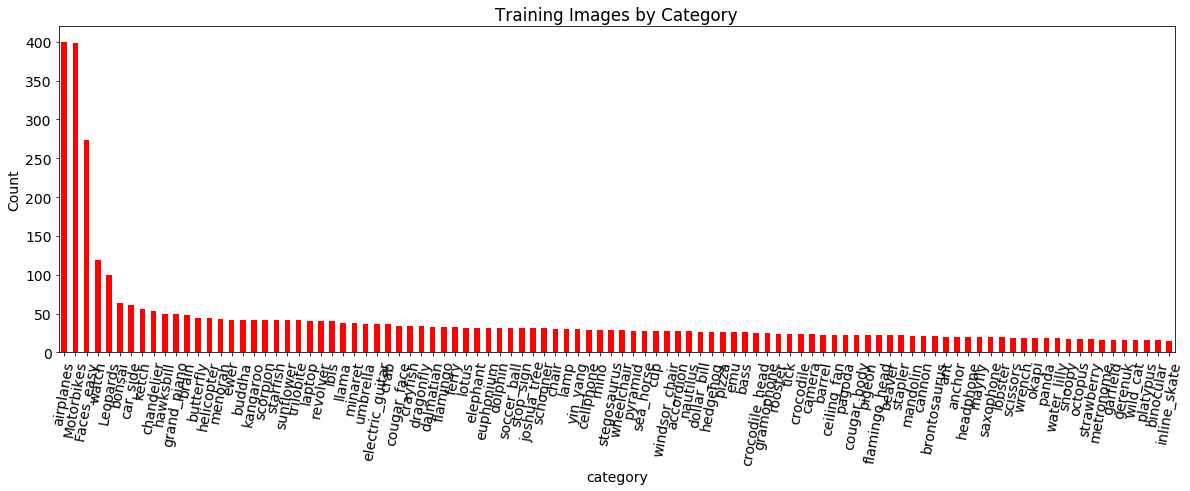

In [5]:
cat_df.set_index('category')['n_train'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80); plt.ylabel('Count'); plt.title('Training Images by Category');

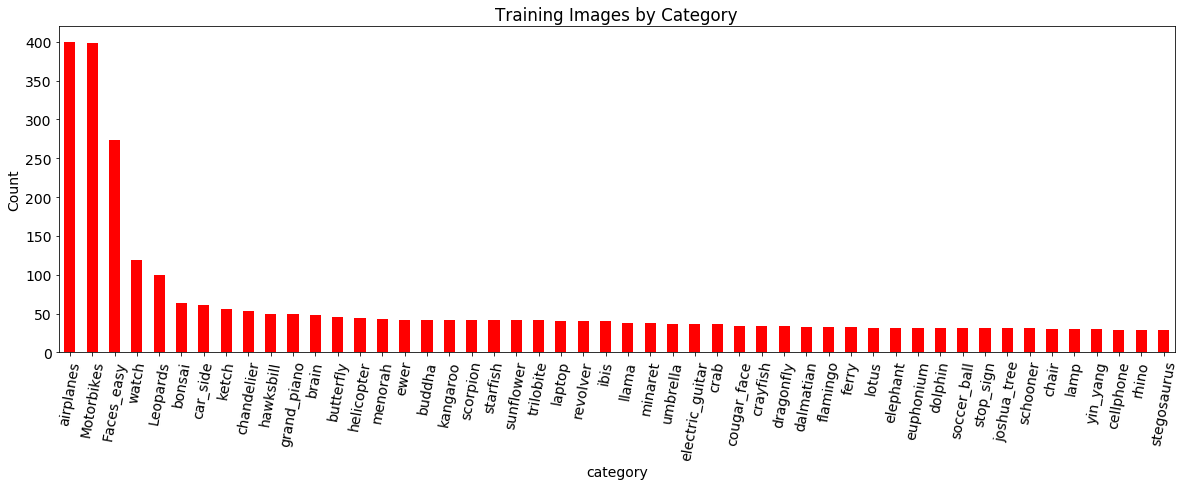

In [6]:
# Only top 50 categories
cat_df.set_index('category').iloc[:50]['n_train'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=80); plt.ylabel('Count'); plt.title('Training Images by Category');

The images themselves have vastly different shapes. We can see this by looking at the stats of images sizes by category.

In [7]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                             \
            count        mean        std    min    25%    50%     75%    max   
category                                                                       
Faces_easy  274.0  318.481752  23.532412  259.0  302.0  318.0  331.75  380.0   
Leopards    100.0  138.240000  23.580989  128.0  128.0  128.0  128.00  192.0   
Motorbikes  398.0  164.899497  19.511540  121.0  151.0  163.0  175.00  261.0   
accordion    27.0  263.851852  35.769243  199.0  233.0  265.0  300.00  300.0   
airplanes   400.0  158.455000  30.847397  101.0  141.0  154.0  170.25  494.0   

            width                                                             
            count        mean        std    min    25%    50%     75%    max  
category                                                                      
Faces_easy  274.0  275.010949  19.471494  249.0  267.0  272.5  281.75  433.0  
Leopards    100.0  181.760000  23.580989  128.0  192.0  192.0  192.00  192.0  
Motorbikes  398.0  262.826633   3.382068  249.0  261.0  261.0  263.00  282.0  
accordion    27.0  280.333333  30.849511  209.0  266.5  300.0  300.00  300.0  
airplanes   400.0  402.137500   8.804965  356.0  396.0  401.0  406.00  457.0

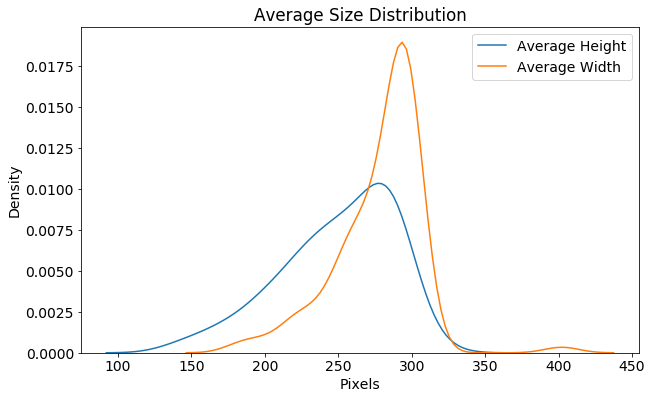

In [8]:
plt.figure(figsize = (10, 6))
sns.kdeplot(img_dsc['height']['mean'], label = 'Average Height')
sns.kdeplot(img_dsc['width']['mean'], label = 'Average Width');
plt.xlabel('Pixels'); plt.ylabel('Density'); plt.title('Average Size Distribution');

When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images.

(300, 187, 3)

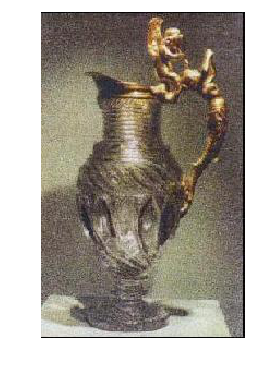

In [9]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example image
x = Image.open(traindir + 'ewer/image_0002.jpg')
np.array(x).shape
imshow(x)

# Image Transforms

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel using a mean and standard deviation. This is done using image `transforms`, which prepare our data for a neural network.?

### Data Augmentation

Because there are a limited number of images in some categories, we can use the idea of image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each time, so the network effectively sees many different versions of the same image. The validation and testing data is not augmented but is only resized and normalized.

In [10]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224), # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. We then iterate through all the batches in the `DataLoader`. 

In [11]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [12]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

The shape of a batch is `(batch_size, color_channels, height, width)`. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


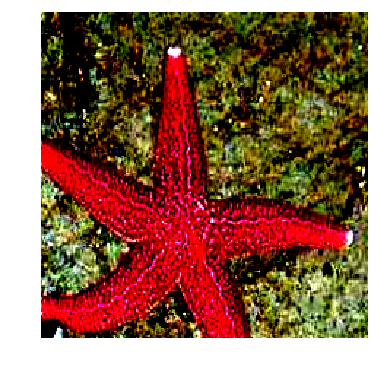

In [13]:
imshow(features.numpy()[15].transpose(1, 2, 0))

There should be 100 different classes. We can confirm this as follows.

In [14]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 100 different classes.


100

# Loading in a Pre-Trained Model

PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. What we want to do with pretrained models is freeze the early layers, and replace the classification module with our own. 

In [15]:
model_options = pd.read_csv('models.csv')
model_options

,model,params
0,AlexNet,61100840
1,DenseNet,7978856
2,Inception3,27161264
3,SqueezeNet,1248424
4,alexnet,61100840
5,densenet121,7978856
6,densenet161,28681000
7,densenet169,14149480
8,densenet201,20013928
9,inception_v3,27161264


## Process to Use Pre-Trained Model

We'll illustrate the process by using one model, vgg16.

In [16]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Freeze Early layers

In [17]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

### Add on Custom Classifier

In [18]:
n_inputs = model.classifier[6].in_features
        
# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): LogSoftmax()
  )
)

Now only the final layers of the model are trainable.

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,335,076 total parameters.
1,074,532 training parameters.


### Move to GPU 

In [20]:
if train_on_gpu:
        model = model.to('cuda')
    
if multi_gpu:
    model = nn.DataParallel(model)

## Function to Load in Pretrained Model

We can refactor all that code into a single function that returns a pretrained model. This only accepts the vgg16 or resnet50 at the moment but can be extended.

In [21]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision
    
    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)
        
    Return
    --------
        model (PyTorch model): cnn
    
    """
    
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features
        
        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)


        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
            
    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')
    
    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [22]:
model = get_pretrained_model('vgg16')
summary(model.module, input_size=(3, 224, 224), 
        batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

In [25]:
print(model.module.classifier[6])

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=256, out_features=100, bias=True)
  (4): LogSoftmax()
)
135,335,076 total parameters.
1,074,532 training parameters.


#### Mapping of Classes to Indexes

To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [26]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Faces_easy'),
 (1, 'Leopards'),
 (2, 'Motorbikes'),
 (3, 'accordion'),
 (4, 'airplanes'),
 (5, 'anchor'),
 (6, 'ant'),
 (7, 'barrel'),
 (8, 'bass'),
 (9, 'beaver')]

# Training Loss and Optimizer

The loss is the negative log likelihood and the optimizer is the Adam optimizer. The loss keeps track of the gradients of the weights with respect to the loss while the optimizer is the method used to update the weights with the gradients.

In [27]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Below we can look at the parameters (weights) that will be updated by the optimizer during training.

In [28]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([100, 256])
torch.Size([100])


# Training

The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set.

In [58]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): number of epochs to print

    Returns
    --------
        model (PyTorch model): trained cnn with best weights

    """

    # Early stopping details
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0

    # Number of epochs already trained
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Iterate through epochs
    for epoch in range(n_epochs):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors on gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            # Track training
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()
                
                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)
                    
                    # Validation loss
                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)
                
                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
                
                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    print(f'\nEpoch: {epoch} \t {epochs_no_improve} epochs with no improvement.\n')
                    
                    # Trigger early stopping 
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epochs}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer
                        return model
    
    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    return model

In [30]:
model = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 42.29 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.4508 	Validation Loss: 0.4563
		Training Accuracy: 87.20%	 Validation Accuracy: 87.41%
Epoch: 3	100.00% complete. 42.46 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2491 	Validation Loss: 0.4004
		Training Accuracy: 92.85%	 Validation Accuracy: 89.12%
Epoch: 5	100.00% complete. 44.59 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1579 	Validation Loss: 0.4305
		Training Accuracy: 94.72%	 Validation Accuracy: 87.74%

Epoch: 5 	 1 epochs with no improvement.

Epoch: 6	100.00% complete. 42.50 seconds elapsed in epoch.
Epoch: 6 	 2 epochs with no improvement.

Epoch: 7	100.00% complete. 42.27 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.1430 	Validation Loss: 0.4001
		Training Accuracy: 95.23%	 Validation Accuracy: 89.93%

Epoch: 7 	 3 epochs with no improvement.

Epoch: 8	100.00% complete. 42.62 seconds elapsed in epoch.
Epoch: 8 	 4 epochs with no i

# Saving Model

We want to save the complete best model as is done below.

In [31]:
def save_checkpoint(model, path, model_name):
    """Save a PyTorch model
    
    Params
    --------
        model (PyTorch model): model to save
        path (str, must end in '.pth'): location to save model
        model_name (str): name of the model (must be either 'vgg16' or 'resnet50')
        
    Returns
    --------
        None, save the `model` to `path`
    
    """
    
    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()
    
    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()
            
    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    
    # Save the data to the path
    torch.save(checkpoint, path)

In [32]:
save_checkpoint(model, path = checkpoint_path, model_name = 'vgg16')

## Load in a Checkpoint

Now we need to write the function to load in the checkpoint. This has the same arguments as the `save_checkpoint` but returns a model from a saved checkpoint.

In [33]:
def load_checkpoint(model, path, model_name):
    """Load a PyTorch model checkpoint
    
    Params
    --------
        model (PyTorch model): model to save
        path (str, must end in '.pth'): location to save model
        model_name (str): name of the model (must be either 'vgg16' or 'resnet50')
        
    Returns
    --------
        
        model (PyTorch model): cnn with weights loaded 
        optimizer (PyTorch optimizer): an optim instance for training the model
    
    """
    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model.classifier = checkpoint['classifier']
    elif model_name == 'resnet50':
        model.fc = checkpoint['fc']
        
    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    if multi_gpu:
        model = nn.DataParallel(model)
        
    if train_on_gpu:
        model = model.to('cuda')
        
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    return model, optimizer

In [57]:
model, optimizer = load_checkpoint(models.vgg16(pretrained=True), 
                                   path = checkpoint_path, 
                                   model_name='vgg16')

summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)

135,335,076 total parameters.
1,074,532 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 2

# Inference

After the model has been trained, we want to see how well it does on predictions. For that, we can test on the entire holdout testing set as well as on individual images.

### Function to Process Image into a PyTorch tensor for predictions

In [35]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""
    
    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))
    
    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256
    
    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)
    
    return img_tensor

In [36]:
x = process_image(testdir + 'dragonfly/' + 'image_0015.jpg')
x.shape

torch.Size([3, 224, 224])

Next we write a function that plots a PyTorch tensor as an image. 

In [37]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()
    
    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip the image pixel values
    image = 255 * np.clip(image, 0, 1)
    
    ax.imshow(image); plt.axis('off')
    
    return ax, image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


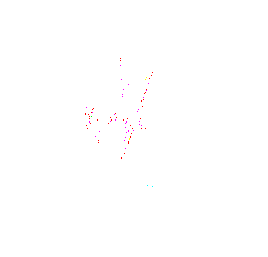

In [38]:
ax, image = imshow_tensor(x)

## Function to make predictions

The next function makes predictions on a single image. It will display the topk predictions for the image.

In [39]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model
    
    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return
    
    Returns
    
    """
    real_class = image_path.split('/')[-2]
    
    # Convert to pytorch tensor
    img_tensor = process_image(image_path)
    
    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)
    
    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)
        
        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim = 1)
        
        # Extract the actual classes and probabilities
        top_classes = [model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]]
        top_p = topk.cpu().numpy()[0]
        
        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [40]:
def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path

random_test_image()

In [41]:
predict(random_test_image(), model)

(tensor([[[ 1.2084,  1.4301,  1.2766,  ...,  2.0101,  2.1295,  1.7372],
          [ 1.2766,  1.1401,  1.0378,  ...,  2.0101,  1.9930,  1.5325],
          [ 1.3448,  1.0549,  1.0549,  ...,  1.9760,  1.8225,  1.2766],
          ...,
          [-1.8791, -1.8109, -1.6915,  ...,  1.9078,  1.7031,  1.8054],
          [-1.8962, -1.8620, -1.7597,  ...,  1.9419,  1.9930,  1.9078],
          [-1.8962, -1.9132, -1.8791,  ...,  1.8225,  1.8736,  1.7713]],
 
         [[ 1.0684,  1.2951,  1.1730,  ...,  1.7310,  1.8531,  1.4520],
          [ 1.1381,  1.0335,  0.9289,  ...,  1.7310,  1.7136,  1.2427],
          [ 1.2079,  0.9463,  0.9463,  ...,  1.6961,  1.5392,  0.9812],
          ...,
          [-1.7567, -1.6869, -1.5649,  ...,  1.7485,  1.5392,  1.6438],
          [-1.7741, -1.7393, -1.6346,  ...,  1.7833,  1.8357,  1.7485],
          [-1.7741, -1.7916, -1.7567,  ...,  1.6613,  1.7136,  1.6090]],
 
         [[ 1.0081,  1.1990,  1.0254,  ...,  1.7199,  1.8414,  1.4074],
          [ 1.0775,  0.9212,

In [42]:
predict(random_test_image(), model)

(tensor([[[-0.4633, -0.4633, -0.4633,  ..., -0.6339, -0.6339, -0.6339],
          [-0.4292, -0.4292, -0.4292,  ..., -0.6339, -0.6339, -0.6339],
          [-0.4292, -0.4292, -0.4292,  ..., -0.6168, -0.6168, -0.6168],
          ...,
          [ 0.4237,  0.4067,  0.3896,  ...,  0.1337,  0.1337,  0.1508],
          [ 0.3725,  0.3555,  0.3384,  ...,  0.0996,  0.0996,  0.1508],
          [ 0.3725,  0.3725,  0.3725,  ...,  0.0655,  0.0655,  0.1167]],
 
         [[-0.4314, -0.4314, -0.4314,  ..., -0.5883, -0.5883, -0.5883],
          [-0.3965, -0.3965, -0.3965,  ..., -0.5883, -0.5883, -0.5883],
          [-0.3965, -0.3965, -0.3965,  ..., -0.5709, -0.5709, -0.5709],
          ...,
          [ 0.4580,  0.4406,  0.4231,  ...,  0.2139,  0.2139,  0.2313],
          [ 0.4231,  0.4057,  0.3883,  ...,  0.1790,  0.1790,  0.2313],
          [ 0.4231,  0.4231,  0.4231,  ...,  0.1441,  0.1441,  0.1964]],
 
         [[-0.1031, -0.1031, -0.1031,  ..., -0.1204, -0.1204, -0.1204],
          [-0.0683, -0.0683,

### Function to Display Predictions

This function displays the picture along with the `topk` predictions from the model. 

In [43]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""
    
    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index = classes)
    
    # Show the image
    plt.figure(figsize = (12, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax = ax);
    
    # Set title to be the actual class
    ax.set_title(y_obs, size = 20);
    plt.show();
    
    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color = 'blue', edgecolor = 'k',
                                           ax = ax);
    plt.xlabel('Predicted Probability'); plt.ylabel('Classes');
    plt.show();
    
    # Find the number of training images
    n_train_images = len(os.listdir(f'{traindir}/{y_obs}'))
    print(f'{n_train_images} training images for {y_obs}.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


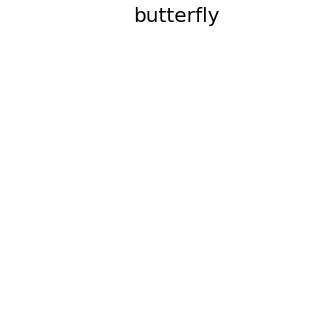

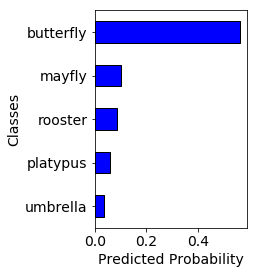

45 training images for butterfly.


In [44]:
display_prediction(random_test_image(), model, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


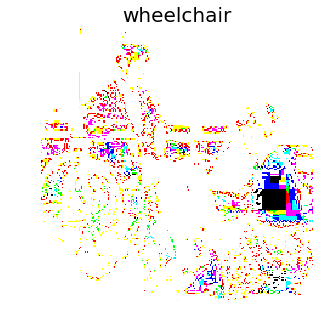

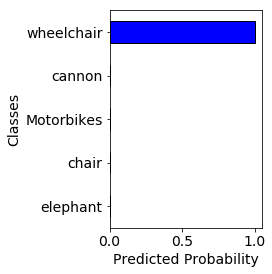

29 training images for wheelchair.


In [45]:
display_prediction(random_test_image(), model, 5)

# Test Accuracy

Image identification models are usually assessed in terms of topk accuracy. We'll assess out model by the top1 and top5 accuracy, that is, the percentage of predictions it gets exactly correct, and the percentage of predictions where the real class is in the top 5 actual classes.

In [46]:
def accuracy(output, target, topk=(1,)):
    """Compute the topk accuracy(s)"""
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        
        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        
        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

## Function to Evaluate Model Over All Classes

The next function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.

In [47]:
def evaluate(model, test_loader, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model
    
    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure
    
    Returns
    --------
        results (DataFrame): results for each category
        
    """
    
    classes = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0
    
    model.eval()
    
    with torch.no_grad():
        
        # Testing loop
        for data, targets in test_loader:
            
            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')
            
            # Raw model output
            out = model(data)
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(pred.unsqueeze(0), 
                                             true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                i += 1
                
    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns = [f'top{i}' for i in topk])
    results['class'] = classes
    results = results.groupby(classes).mean()
    
    return results.reset_index()

In [48]:
results = evaluate(model, dataloaders['test'])
results.head()

,index,top1,top5
0,Faces_easy,100.0,100.0
1,Leopards,100.0,100.0
2,Motorbikes,100.0,100.0
3,accordion,100.0,100.0
4,airplanes,98.5,100.0


## Test Results

In [49]:
results = results.merge(cat_df, left_on = 'index', right_on = 'category').\
                 drop(columns = ['index'])

/usr/local/gcc-6_3_0/openmpi-2_0_1/python/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


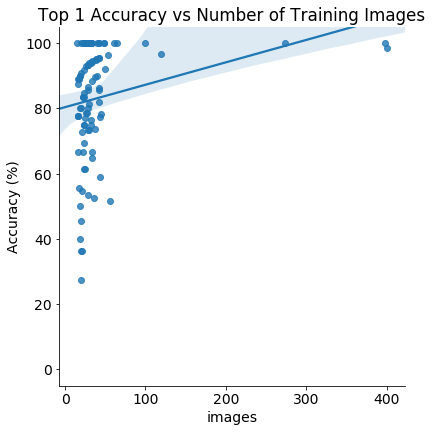

In [50]:
sns.lmplot(y='top1', x='n_train', data = results, height = 6);
plt.xlabel('images'); plt.ylabel('Accuracy (%)');
plt.title('Top 1 Accuracy vs Number of Training Images');
plt.ylim(-5, 105);

In [51]:
results.loc[results['top1'].idxmin]

top1        27.2727
top5        81.8182
category     anchor
n_train          20
n_valid          11
n_test           11
Name: 5, dtype: object

In [52]:
results.loc[results['n_train'].idxmin]

top1                 100
top5                 100
category    inline_skate
n_train               15
n_valid                8
n_test                 8
Name: 51, dtype: object

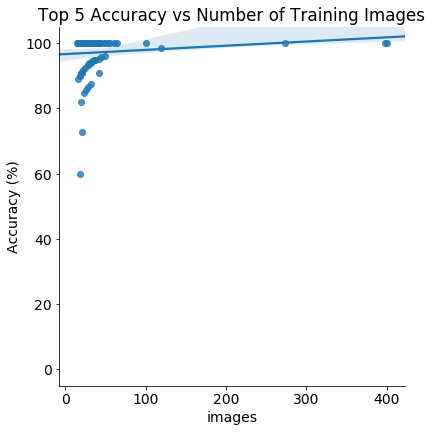

In [53]:
sns.lmplot(y='top5', x='n_train', data = results, height = 6);

plt.xlabel('images'); plt.ylabel('Accuracy (%)');
plt.title('Top 5 Accuracy vs Number of Training Images');
plt.ylim(-5, 105);

In [55]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 5):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']
    
# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top5'].sum()

print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 5 weighted accuracy = {top5_weighted:.2f}%')

Final test top 1 weighted accuracy = 88.51%
Final test top 5 weighted accuracy = 98.14%


# Conclusions

This project taught us the basics of using PyTorch for pretrained neural networks. We saw how to use a network that has already been trained on a large set of images so we don't have to spend a long time getting the model up to speed. Truly, we live in an incredible age for deep learning with the availability of resources, and it's only getting better! Hopefully, this notebook has prepared you to take on your own challenges with PyTorch and get started using this library for deep learning.